In [186]:
# NBVAL_IGNORE_OUTPUT
%load_ext watermark
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
%watermark -v --iversions

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
matplotlib       3.1.3
scipy            1.4.1
numpy            1.18.1
krotov           1.1.0+dev
qutip            4.5.0
matplotlib.pylab 1.18.1
CPython 3.7.7
IPython 7.13.0


In [187]:
def hamiltonian(omega=1.0, ampl0=0.2):
    """Two-level-system Hamiltonian

    Args:
        omega (float): energy separation of the qubit levels
        ampl0 (float): constant amplitude of the driving field
    """
    H0 = -0.5 * omega * qutip.operators.sigmaz()
    H1 = qutip.operators.sigmax()

    def guess_control(t, args):
        return ampl0 * krotov.shapes.flattop(
            t, t_start=0, t_stop=5, t_rise=0.3, func="blackman"
        )

    return [H0, [H1, guess_control]]

In [188]:
H = hamiltonian()

In [189]:
tlist = np.linspace(0, 5, 500)

In [190]:
def plot_pulse(pulse, tlist):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, args=None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time')
    ax.set_ylabel('pulse amplitude')
    plt.show(fig)

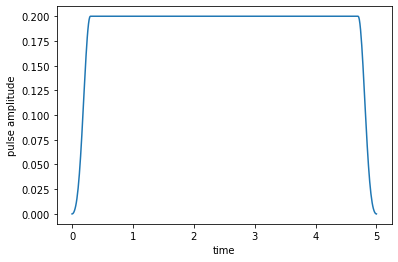

In [191]:
plot_pulse(H[1][1], tlist)

In [192]:
def arrayToGateMatrix(gateArray, dim):
    return qutip.Qobj(gateArray.reshape((2**dim, 2**dim)), dims=[[2] * dim, [2] * dim])

In [193]:
N = 1
hArray = np.array([ 0,  1, 1, 0])
hGate = arrayToGateMatrix(hArray, N)

In [194]:
def logical_basis(N):
    result = np.zeros(2**(N), dtype = qutip.Qobj)
    for i in range(2**(N)):
        result[i] = qutip.Qobj(qutip.ket(format(i, 'b').zfill(N)))
    return result

In [195]:
objectives = krotov.gate_objectives(
        basis_states=logical_basis(1), gate=hGate, H=H
    )

objectives

[Objective[|Ψ₃₄(2)⟩ to |Ψ₃₅(2)⟩ via [H₁₄[2,2], [H₁₅[2,2], u₈(t)]]],
 Objective[|Ψ₃₅(2)⟩ to |Ψ₃₄(2)⟩ via [H₁₄[2,2], [H₁₅[2,2], u₈(t)]]]]

In [196]:
def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=5, t_rise=0.3, t_fall=0.3, func='blackman'
    )

In [197]:
pulse_options = {
    H[1][1]: dict(lambda_a=5, update_shape=S)
}

In [198]:
proj0 = qutip.ket2dm(qutip.ket("0"))
proj1 = qutip.ket2dm(qutip.ket("1"))

In [199]:
guess_dynamics = objectives[0].mesolve(tlist, e_ops=[proj0, proj1])

In [200]:
def plot_population(result):
    fig, ax = plt.subplots()
    ax.plot(result.times, result.expect[0], label='0')
    ax.plot(result.times, result.expect[1], label='1')
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    plt.show(fig)

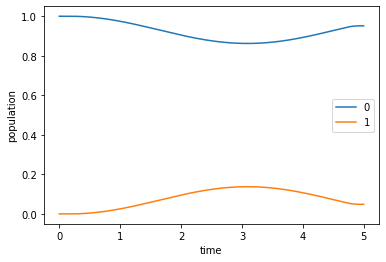

In [201]:
plot_population(guess_dynamics)

In [202]:
opt_result = krotov.optimize_pulses(
    objectives,
    pulse_options=pulse_options,
    tlist=tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_ss,
    info_hook=krotov.info_hooks.print_table(J_T=krotov.functionals.J_T_ss),
    check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below('1e-3', name='J_T'),
        krotov.convergence.check_monotonic_error,
    ),
    store_all_pulses=True,
)

iter.      J_T    ∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     9.51e-01    0.00e+00   9.51e-01        n/a        n/a     2
1     9.24e-01    2.32e-03   9.27e-01  -2.70e-02  -2.47e-02     5
2     8.83e-01    3.53e-03   8.87e-01  -4.11e-02  -3.75e-02     5
3     8.23e-01    5.22e-03   8.28e-01  -6.06e-02  -5.54e-02     5
4     7.38e-01    7.39e-03   7.45e-01  -8.52e-02  -7.78e-02     5
5     6.26e-01    9.75e-03   6.36e-01  -1.11e-01  -1.01e-01     4
6     4.96e-01    1.16e-02   5.07e-01  -1.31e-01  -1.19e-01     4
7     3.62e-01    1.21e-02   3.74e-01  -1.34e-01  -1.22e-01     4
8     2.44e-01    1.09e-02   2.55e-01  -1.18e-01  -1.07e-01     5
9     1.53e-01    8.43e-03   1.62e-01  -9.03e-02  -8.19e-02     5
10    9.20e-02    5.80e-03   9.78e-02  -6.14e-02  -5.56e-02     5
11    5.35e-02    3.66e-03   5.72e-02  -3.85e-02  -3.48e-02     5
12    3.06e-02    2.19e-03   3.28e-02  -2.29e-02  -2.07e-02     5
13    1.73e-02    1.27e-03   1.86e-02  -1.33e-02  -1.20e-02     5
14    9.79

In [203]:
opt_result

Krotov Optimization Result
--------------------------
- Started at 2020-03-28 15:01:45
- Number of objectives: 2
- Number of iterations: 18
- Reason for termination: Reached convergence: J_T < 1e-3
- Ended at 2020-03-28 15:03:23 (0:01:38)

In [204]:
opt_dynamics = opt_result.optimized_objectives[0].mesolve(
    tlist, e_ops=[proj0, proj1])

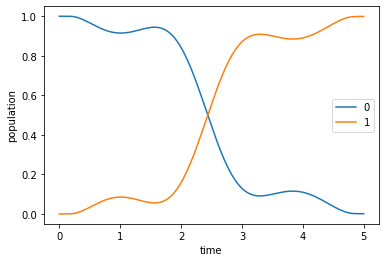

In [205]:
plot_population(opt_dynamics)

In [206]:
def plot_iterations(opt_result):
    """Plot the control fields in population dynamics over all iterations.

    This depends on ``store_all_pulses=True`` in the call to
    `optimize_pulses`.
    """
    fig, [ax_ctr, ax_dyn] = plt.subplots(nrows=2, figsize=(8, 10))
    n_iters = len(opt_result.iters)
    for (iteration, pulses) in zip(opt_result.iters, opt_result.all_pulses):
        controls = [
            krotov.conversions.pulse_onto_tlist(pulse)
            for pulse in pulses
        ]
        objectives = opt_result.objectives_with_controls(controls)
        dynamics = objectives[0].mesolve(
            opt_result.tlist, e_ops=[proj0, proj1]
        )
        if iteration == 0:
            ls = '--'  # dashed
            alpha = 1  # full opacity
            ctr_label = 'guess'
            pop_labels = ['0 (guess)', '1 (guess)']
        elif iteration == opt_result.iters[-1]:
            ls = '-'  # solid
            alpha = 1  # full opacity
            ctr_label = 'optimized'
            pop_labels = ['0 (optimized)', '1 (optimized)']
        else:
            ls = '-'  # solid
            alpha = 0.5 * float(iteration) / float(n_iters)  # max 50%
            ctr_label = None
            pop_labels = [None, None]
        ax_ctr.plot(
            dynamics.times,
            controls[0],
            label=ctr_label,
            color='black',
            ls=ls,
            alpha=alpha,
        )
        ax_dyn.plot(
            dynamics.times,
            dynamics.expect[0],
            label=pop_labels[0],
            color='#1f77b4',  # default blue
            ls=ls,
            alpha=alpha,
        )
        ax_dyn.plot(
            dynamics.times,
            dynamics.expect[1],
            label=pop_labels[1],
            color='#ff7f0e',  # default orange
            ls=ls,
            alpha=alpha,
        )
    ax_dyn.legend()
    ax_dyn.set_xlabel('time')
    ax_dyn.set_ylabel('population')
    ax_ctr.legend()
    ax_ctr.set_xlabel('time')
    ax_ctr.set_ylabel('control amplitude')
    plt.show(fig)

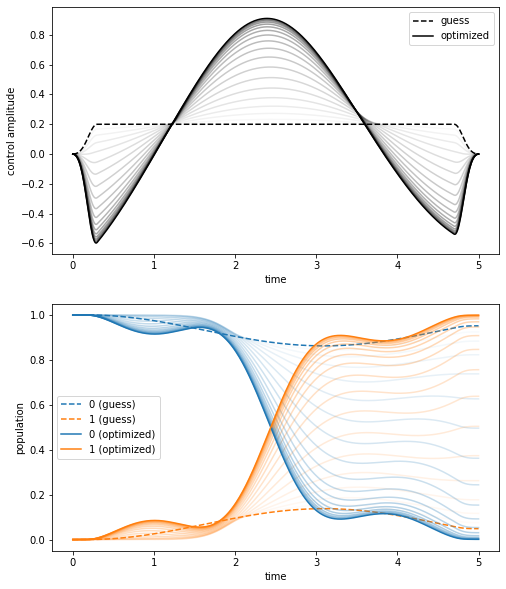

In [207]:
plot_iterations(opt_result)

In [208]:
def logical_basis(N):
    result = np.zeros(2**(N), dtype = qutip.Qobj)
    for i in range(2**(N)):
        result[i] = qutip.Qobj(qutip.ket(format(i, 'b').zfill(N)))
    return result

In [209]:
def parse_pauli_str(pauli_string):
    coeff_and_op = pauli_string.split()
    coeff = (float(coeff_and_op[-2]))
    pauliOp = coeff_and_op[-1]
    if pauliOp[0] == 'X':
        return coeff * qutip.operators.sigmax()
    if pauliOp[0] == 'Y':
        return coeff * qutip.operators.sigmay()
    if pauliOp[0] == 'Z':
        return coeff * qutip.operators.sigmay()
print(parse_pauli_str('1.000000 X0'))

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 1.]
 [1. 0.]]
